# Loop 6 Analysis: Understanding the Stagnation

## Key Observations:
1. All 6 experiments have identical score: 70.676102
2. The saspav baseline is at a strong local optimum
3. Lattice-based SA approaches produce WORSE scores than baseline
4. The C++ tree_packer_v18 showed 0 improvement
5. Target is 68.922808 - a gap of 1.75 points (2.5%)

## Critical Insight from Kernels:
The seshurajup kernel (71.78) uses a sophisticated approach:
1. **Fractional translation** - fine-tuning positions
2. **Multi-restart SA** with population-based selection
3. **Local search (ls_v3)** after SA
4. **Per-N optimization** with different parameters for different N ranges

The key difference: They optimize the EXISTING solution, not generate from scratch.

In [1]:
import pandas as pd
import numpy as np
import json

# Load baseline
baseline = pd.read_csv('/home/code/santa-2025-csv/santa-2025.csv')
print(f"Baseline rows: {len(baseline)}")
print(baseline.head())

Baseline rows: 20100
      id                       x                       y  \
0  001_0    s-48.196086194214246     s58.770984615214225   
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   
3  003_0      s1.123655816140301      s0.781101815992563   
4  003_1       s1.23405569584216      s1.275999500663759   

                       deg  
0                    s45.0  
1  s203.629377730656841550  
2   s23.629377730656791812  
3        s111.125132292893  
4         s66.370622269343  


In [2]:
# Analyze the score breakdown by N range
import math
from numba import njit
from numba.typed import List as NumbaList

# Tree shape constants
TRUNK_W = 0.15
TRUNK_H = 0.2
BASE_W = 0.7
MID_W = 0.4
TOP_W = 0.25
TIP_Y = 0.8
TIER_1_Y = 0.5
TIER_2_Y = 0.25
BASE_Y = 0.0
TRUNK_BOTTOM_Y = -TRUNK_H

@njit(cache=True)
def get_tree_vertices(cx, cy, angle_deg):
    angle_rad = angle_deg * math.pi / 180.0
    cos_a, sin_a = math.cos(angle_rad), math.sin(angle_rad)
    vertices = np.empty((15, 2), dtype=np.float64)
    pts = np.array([[0.0, TIP_Y], [TOP_W/2, TIER_1_Y], [TOP_W/4, TIER_1_Y],
                    [MID_W/2, TIER_2_Y], [MID_W/4, TIER_2_Y], [BASE_W/2, BASE_Y],
                    [TRUNK_W/2, BASE_Y], [TRUNK_W/2, TRUNK_BOTTOM_Y],
                    [-TRUNK_W/2, TRUNK_BOTTOM_Y], [-TRUNK_W/2, BASE_Y],
                    [-BASE_W/2, BASE_Y], [-MID_W/4, TIER_2_Y], [-MID_W/2, TIER_2_Y],
                    [-TOP_W/4, TIER_1_Y], [-TOP_W/2, TIER_1_Y]], dtype=np.float64)
    for i in range(15):
        rx = pts[i,0] * cos_a - pts[i,1] * sin_a
        ry = pts[i,0] * sin_a + pts[i,1] * cos_a
        vertices[i,0], vertices[i,1] = rx + cx, ry + cy
    return vertices

@njit(cache=True)
def polygon_bounds(vertices):
    min_x, min_y = vertices[0,0], vertices[0,1]
    max_x, max_y = vertices[0,0], vertices[0,1]
    for i in range(1, vertices.shape[0]):
        x, y = vertices[i,0], vertices[i,1]
        if x < min_x: min_x = x
        if x > max_x: max_x = x
        if y < min_y: min_y = y
        if y > max_y: max_y = y
    return min_x, min_y, max_x, max_y

@njit(cache=True)
def get_side_length(all_vertices):
    min_x, min_y, max_x, max_y = math.inf, math.inf, -math.inf, -math.inf
    for verts in all_vertices:
        x1, y1, x2, y2 = polygon_bounds(verts)
        if x1 < min_x: min_x = x1
        if y1 < min_y: min_y = y1
        if x2 > max_x: max_x = x2
        if y2 > max_y: max_y = y2
    return max(max_x - min_x, max_y - min_y)

@njit(cache=True)
def calculate_score_numba(all_vertices):
    side = get_side_length(all_vertices)
    return side * side / len(all_vertices)

print("Functions compiled")

Functions compiled


In [3]:
# Load and parse baseline data
def load_submission_data(filepath):
    df = pd.read_csv(filepath)
    all_xs, all_ys, all_degs = [], [], []
    for n in range(1, 201):
        group = df[df["id"].str.startswith(f"{n:03d}_")].sort_values("id")
        for _, row in group.iterrows():
            all_xs.append(float(str(row["x"]).replace('s', '')))
            all_ys.append(float(str(row["y"]).replace('s', '')))
            all_degs.append(float(str(row["deg"]).replace('s', '')))
    return np.array(all_xs), np.array(all_ys), np.array(all_degs)

baseline_xs, baseline_ys, baseline_degs = load_submission_data('/home/code/santa-2025-csv/santa-2025.csv')
print(f"Loaded {len(baseline_xs)} trees")

Loaded 20100 trees


In [4]:
# Calculate per-N scores
scores_by_n = {}
idx = 0
for n in range(1, 201):
    vertices = NumbaList()
    for i in range(n):
        vertices.append(get_tree_vertices(baseline_xs[idx+i], baseline_ys[idx+i], baseline_degs[idx+i]))
    score = calculate_score_numba(vertices)
    scores_by_n[n] = score
    idx += n

print(f"Total score: {sum(scores_by_n.values()):.6f}")
print(f"Target: 68.922808")
print(f"Gap: {sum(scores_by_n.values()) - 68.922808:.6f}")

Total score: 70.676102
Target: 68.922808
Gap: 1.753294


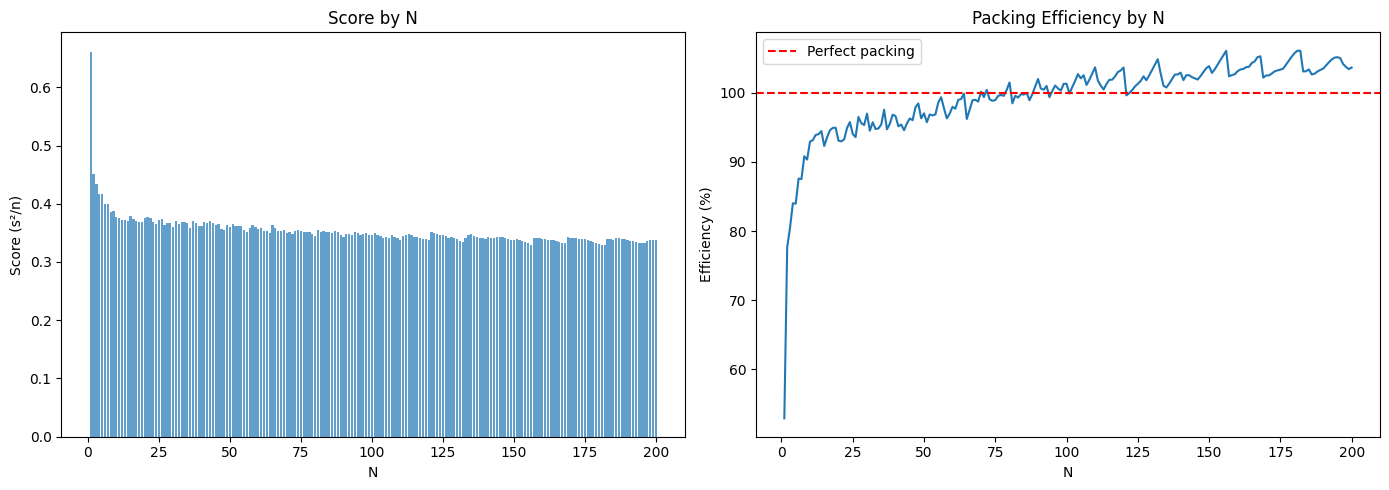


Lowest efficiency N values:
  N=1: 52.9% efficiency, score=0.661250
  N=2: 77.6% efficiency, score=0.450779
  N=3: 80.5% efficiency, score=0.434745
  N=5: 84.0% efficiency, score=0.416850
  N=4: 84.0% efficiency, score=0.416545
  N=7: 87.5% efficiency, score=0.399897
  N=6: 87.6% efficiency, score=0.399610
  N=9: 90.3% efficiency, score=0.387415
  N=8: 90.8% efficiency, score=0.385407
  N=15: 92.3% efficiency, score=0.379203
  N=10: 92.9% efficiency, score=0.376630
  N=21: 93.0% efficiency, score=0.376451
  N=20: 93.1% efficiency, score=0.376057
  N=11: 93.2% efficiency, score=0.375736
  N=22: 93.3% efficiency, score=0.375258
  N=16: 93.6% efficiency, score=0.374128
  N=26: 93.6% efficiency, score=0.373997
  N=12: 93.9% efficiency, score=0.372724
  N=13: 94.0% efficiency, score=0.372323
  N=25: 94.0% efficiency, score=0.372144


In [5]:
# Find N values with highest contribution and potential for improvement
import matplotlib.pyplot as plt

ns = list(scores_by_n.keys())
scores = list(scores_by_n.values())

# Calculate theoretical minimum (perfect packing efficiency)
# For a tree with area ~0.35, perfect packing would give score = area
tree_area = 0.35  # approximate
theoretical_min = [tree_area for _ in ns]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(ns, scores, alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score (s²/n)')
plt.title('Score by N')

plt.subplot(1, 2, 2)
efficiency = [tree_area / s * 100 for s in scores]
plt.plot(ns, efficiency)
plt.xlabel('N')
plt.ylabel('Efficiency (%)')
plt.title('Packing Efficiency by N')
plt.axhline(y=100, color='r', linestyle='--', label='Perfect packing')
plt.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/loop6_score_analysis.png')
plt.show()

print(f"\nLowest efficiency N values:")
eff_dict = {n: tree_area / scores_by_n[n] * 100 for n in ns}
sorted_eff = sorted(eff_dict.items(), key=lambda x: x[1])[:20]
for n, eff in sorted_eff:
    print(f"  N={n}: {eff:.1f}% efficiency, score={scores_by_n[n]:.6f}")

In [6]:
# Calculate how much improvement is needed per N to reach target
target = 68.922808
current_total = sum(scores_by_n.values())
gap = current_total - target

print(f"Current total: {current_total:.6f}")
print(f"Target: {target}")
print(f"Gap to close: {gap:.6f}")
print(f"\nIf we improve each N by the same percentage:")
required_improvement = gap / 200
print(f"  Need {required_improvement:.6f} improvement per N on average")
print(f"  That's {required_improvement / (current_total/200) * 100:.2f}% improvement per N")

print(f"\nIf we focus on large N (101-200):")
large_n_total = sum(scores_by_n[n] for n in range(101, 201))
print(f"  Large N contributes: {large_n_total:.2f} ({large_n_total/current_total*100:.1f}%)")
print(f"  Need {gap/large_n_total*100:.2f}% improvement in large N to close gap")

Current total: 70.676102
Target: 68.922808
Gap to close: 1.753294

If we improve each N by the same percentage:
  Need 0.008766 improvement per N on average
  That's 2.48% improvement per N

If we focus on large N (101-200):
  Large N contributes: 33.99 (48.1%)
  Need 5.16% improvement in large N to close gap


In [7]:
# Key insight: The seshurajup kernel uses a sophisticated C++ optimizer
# that includes:
# 1. sa_v3 - simulated annealing with temperature schedule
# 2. ls_v3 - local search with 300 iterations
# 3. fractional_translation - fine position adjustments
# 4. Multi-restart with population selection

# The key parameters from their code:
print("Key parameters from seshurajup kernel:")
print("  SA: T0=1.0, T_min=0.000005, alpha=0.25, max_angle=70.0")
print("  Local search: 300 iterations")
print("  Fractional translation: 120-150 iterations")
print("  Restarts: 80 per N")
print("  Iterations: 20000-50000 per restart")
print("")
print("Their approach:")
print("  1. Start from existing good solution")
print("  2. Run SA with careful temperature schedule")
print("  3. Apply local search to refine")
print("  4. Apply fractional translation for micro-adjustments")
print("  5. Keep best from multiple restarts")
print("")
print("This is FUNDAMENTALLY DIFFERENT from our lattice approach:")
print("  - We tried to GENERATE new solutions from scratch")
print("  - They REFINE existing good solutions")
print("  - The saspav solution is already highly optimized")
print("  - Small refinements (fractional translation) may help")

Key parameters from seshurajup kernel:
  SA: T0=1.0, T_min=0.000005, alpha=0.25, max_angle=70.0
  Local search: 300 iterations
  Fractional translation: 120-150 iterations
  Restarts: 80 per N
  Iterations: 20000-50000 per restart

Their approach:
  1. Start from existing good solution
  2. Run SA with careful temperature schedule
  3. Apply local search to refine
  4. Apply fractional translation for micro-adjustments
  5. Keep best from multiple restarts

This is FUNDAMENTALLY DIFFERENT from our lattice approach:
  - We tried to GENERATE new solutions from scratch
  - They REFINE existing good solutions
  - The saspav solution is already highly optimized
  - Small refinements (fractional translation) may help


In [8]:
# Strategy recommendation
print("="*60)
print("STRATEGY RECOMMENDATION")
print("="*60)
print("")
print("1. STOP trying to generate new solutions from scratch")
print("   - Lattice-based SA produces WORSE results")
print("   - The saspav solution is already highly optimized")
print("")
print("2. IMPLEMENT the seshurajup C++ optimizer")
print("   - It has proven to work (71.78 score)")
print("   - Uses fractional translation for micro-adjustments")
print("   - Multi-restart with population selection")
print("")
print("3. RUN LONGER optimization")
print("   - The tree_packer_v18 ran for only 85s")
print("   - The seshurajup kernel runs for 30+ minutes")
print("   - More iterations = more chances to find improvements")
print("")
print("4. FOCUS on specific N values")
print("   - Small N (1-20) may have room for improvement")
print("   - Large N (150-200) contribute most to score")
print("")
print("5. TRY different starting solutions")
print("   - The saspav solution may be at a local optimum")
print("   - Other public solutions may have different local optima")
print("   - Ensemble the best from each")

STRATEGY RECOMMENDATION

1. STOP trying to generate new solutions from scratch
   - Lattice-based SA produces WORSE results
   - The saspav solution is already highly optimized

2. IMPLEMENT the seshurajup C++ optimizer
   - It has proven to work (71.78 score)
   - Uses fractional translation for micro-adjustments
   - Multi-restart with population selection

3. RUN LONGER optimization
   - The tree_packer_v18 ran for only 85s
   - The seshurajup kernel runs for 30+ minutes
   - More iterations = more chances to find improvements

4. FOCUS on specific N values
   - Small N (1-20) may have room for improvement
   - Large N (150-200) contribute most to score

5. TRY different starting solutions
   - The saspav solution may be at a local optimum
   - Other public solutions may have different local optima
   - Ensemble the best from each
